In [36]:
from pylab import *
import numpy as np
import scipy as sp

# Homework 2: An HI model of the MW

This week we'll be constructing models for the properties of HI in the Galaxy using the results of HI 21 cm surveys. 

## I. HI galactic structure
We'll be taking a spectrum along a specific line of sight defined by the galactocentric longitude $l$ and trying to calculate the physical neutral hydrogen number density $n_H$. 

The spectra for each $l$ are in their own `.txt` file, with columns for the radial velocity $v_{lsr}$ in km/s and brightness $T_b$ in K.
In order to spatially map this emission, we're going to calculate the kinematic distances for a sample radial velocity assuming a flat Galactic rotation curve. 
The expression for the radial velocity is a function of the galactic rotation curve $v_0$ scaled to the location of the solar circle $r_0$ and the galactice longitude and latitude, $l$ and $b$. We're going to restrict this to the midplane, taking spectra only for $b=0$. For a flat rotation curve, the expression becomes:

$v_{lsr} = v_0\sin(l)(r_0/r - 1)$

Using this relationship, we can calculate the galactocentric radius, $r$ from the measured radial velocities $v_{lsr}$. The law of cosines then gives a solution for the distance from the Sun as:

$s = r_0 \cos(l) \pm \sqrt(r^2 - r_0^2 \sin^2 (l))$

This presents two solutions for the line of sight distance when $r < r_0$, an effect known as the kinematic distance anomaly (KDA).  
<img src = "kda.png" width=20% height=20%>
Figure is Figure 1 from [Roman-Duval et al., 2009](https://ui.adsabs.harvard.edu/abs/2009ApJ...699.1153R/abstract). See ref for more details.

To make our lives easier, here, we are going to exclude our analysis to everything outside of the solar circle, such that $r/r_0 > 1$, so that there is only one solution for the source distance $s$. Since the galactic rotation curve is still a bit wiggly, departing from the solar circle value by more than 10 km/s for R > 30 kpc, (see Figure 2 in Kalberla & Kerp 2009), let's also prescribe the limit to be $r/r_0 < 30/r_0$. 
For angles $l < 180$, the radial los velocity component of galactic rotation $v_0 \sin(l) > 0$, while for $l> 180$, $v_0 sin(l) < 0$ -- looking toward the current vs. against it. 

For our purposes we will adopt $r_0 = 8.5 \mathrm{kpc}$ and $v_0 = 220 \mathrm{km /s }$

### Part a
Derive the threshhold of $v_{lsr}$ for:  
a. $r/r0 = 1$  
b. $r/r0 = 30/r_0$  

Use the derived threshhold to define a function below that takes an rmin and rmax and returns a tuple of the corresponding vmin and vmax in terms of $v_0 \sin(l)$

In [82]:
l = 180 #degrees
v0 = 220 #km/s

def get_vlim(rmin, rmax, r0=8.5):
    ratio_a = 1 #threshold a ratio
    ratio_b = 30/r0 #threshold b ratio


    #Now we're going to take the equation for the radial velocity for a flat rotation curve and apply our
    #two r values to it to find the limits
    v_lim_1 = (r0/rmin-1)
    v_lim_2 = (r0/rmax-1)
    #I tried it out in radians, but the vmax value became too small. If I'm incorrect I'd love to learn why we use one 
    #angular unit over the other.
    return (v_lim_1,v_lim_2)

rmin = 8.5 #kpc
rmax = 30. #kpc
print("Our rmin and rmax values of (8.5, 30) give us vmin and vmax values of", get_vlim(rmin, rmax), ".")

Our rmin and rmax values of (8.5, 30) give us vmin and vmax values of (0.0, -0.7166666666666667) .


Go to the survey data website: https://www.astro.uni-bonn.de/hisurvey/AllSky_profiles/index.php 
Input a galactic longitude between 30 and 330 degrees (whatever you want!) and click search. You will see a spectrum and a link that says:
`Download this data as an ascii file`. Click the link and save the file to your working directory.

Below I've included a class that reads in this type of spectrum file and a galactic longitude and performs basic calculations.
The function `clean_spectrum` will use the function you just defined to bin the spectrum within the resulting velocity threshholds in order to limit the analysis to those between the defined galactocentric radii. Read over the methods and get acquainted with the properties of the class and make sure you understand how the function you wrote is going to be used.

* **On the website, I selected 81 degrees in the right ascencsion selection. Just because I like the number 81. I saw a beautiful spectrum that mostly was visible clearly in the EBHIS (Effelsberg telescope) representation, and its peak brightness temperature hit ~110 K @ 0 km/s. Since I centered it on 81 degrees in the RA in galactic coordinates, it translated to a requested position of 309.77 degrees RA and 41.46 degrees DEC (which I'm less familiar with working with! More comfortable with h/m/s and deg/s).**

In [83]:
from scipy import stats
pctocm = 3.086e18 #parsec to cm conversion
kpctocm = pctocm*1000 #kiloparsec to cm conversion

#Creating a new class - a new type of object with new instances.
class spec_calc:
    def __init__(self,l,filename,rmin=None,rmax=None): #instantiation, w/args for the class operator
        """ method initializes with galactic longitude l in degrees and filename of spectrum file to read.
        As part of initialization, this will:
        1. read in the spectrum 
        2. clean the spectrum (bin the spectrum in the range vmin and vmax with bins of size dv)
        3. calculate the galactocentric radius of the velocities
        4. calculate the distances from the galactocentric radius"""
        self.l = l
        #Either the spectrum has an rmin/rmax, or it is selected
        if rmin is None:
            self.rmin = 8.5 
        else:
            self.rmin = rmin
        if rmax is None:
            self.rmax = 30.0
        else:
            self.rmax = rmax
        #reading the spectrum and binning the data    
        self.data = self.read_spectrum(filename)
        v_bins, self.T_b = self.clean_spectrum()
        self.vlsr = (v_bins[1:]+ v_bins[:-1])*0.5
        self.dv = np.diff(v_bins)
        r_bins = self.r_gc(v_bins) #bin edges corresponding to the velocity bins in terms of r_gc
        s_bins = self.dist(r_bins) #bin edges corresponding to the velocity bins in terms of los distance
        self.ds = np.abs(np.diff(s_bins)) #width of each bin in los distance
        self.r_ =(r_bins[1:]+r_bins[:-1])*0.5 #galactocentric radii coordinates
        self.s_ = (s_bins[1:]+s_bins[:-1])*0.5 #line of sight distance
    #functions within the spec_calc class
    def read_spectrum(self,filename):
        """ reads in a file with spectral information and returns a list of vlsr [km/s] and Tb [K]"""
        data = np.loadtxt(filename,comments="%")
        vr = data[:,0]
        Tb = data[:,1]
        return (vr, Tb)

    def clean_spectrum(self,dv=2,v0=220.):
        """ returns a binned spectrum with velocity bins of width dv within some threshold vmin and vmax given by the get_lim() function"""
        l = np.radians(self.l)
        vr, Tb = self.data
        v_lim_1, v_lim_2 = get_vlim(rmin=self.rmin,rmax=self.rmax)
        v_lim_1 *= v0*np.sin(l)
        v_lim_2 *= v0*np.sin(l)
        v_min = min(v_lim_1,v_lim_2)
        v_max = max(v_lim_1,v_lim_2)
        bins_e = np.arange(v_min,v_max,dv) #bin_edges
        bins = (bins_e[1:]+bins_e[:-1])*0.5 #bin_centers
        Tb_binned = stats.binned_statistic(vr,Tb,bins=bins_e)[0]
        return bins_e, Tb_binned

    def r_gc(self,vr,r0=8.5,v0=220.):
        """ calculates the galactocentric radius assuming a flat rotation curve"""
        l = np.radians(self.l)
        v_lim = v0*np.sin(l)
        return r0*np.sin(l)*v0/(vr+v_lim)

    def dist(self,r_,r0=8.5):
        """ calculates the kinematic distance of a source based on the galactocentric R and l"""
        l = np.radians(self.l)
        return r0*np.cos(l) + np.sqrt( r_*r_ - r0*r0*np.sin(l)*np.sin(l))


The following script will plot the raw data vs the cleaned spectrum and the converted galactocentric distances for the brightness temperatures. Put in the path to your file for `file_in` and the longitude you chose for `l_in`. If your function works as it should, the resulting $R_{gc}$ should be between 8.5 kpc and 30 kpc.

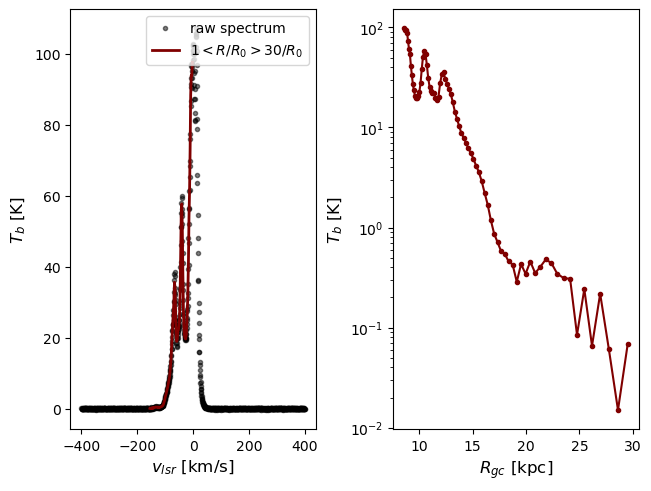

In [84]:
file_in= "/Users/shirin/Documents/CUNYMS/Sp24/StarsAndPlanets/spectrum.txt"
l_in = 81 #degrees
spec = spec_calc(filename=file_in,l=l_in)

f,ax = subplots(1,2,constrained_layout=True,dpi=100)
ax[0].plot(*spec.data,'k.',alpha=0.5,label='raw spectrum')
ax[0].plot(spec.vlsr, spec.T_b,color='maroon',lw=2,label=r'$1 < R/R_0 > 30/R_0$')
ax[0].set_xlabel(r'$v_{lsr}$ [km/s]',fontsize=12)
ax[0].set_ylabel(r'$T_b$ [K]',fontsize=12)
ax[0].legend(loc=1)

ax[1].plot(spec.r_, spec.T_b,'.-',color='maroon')
ax[1].set_xlabel(r'$R_{gc}$ [kpc]',fontsize=12)
ax[1].set_ylabel(r'$T_b$ [K]',fontsize=12)
ax[1].set_yscale('log')

### Part b
Now we have a mapping of each velocity bin to a distance, we want to get an understanding of what the column is at each distance. 
Of course, we could sum over the entire spectrum and get the total column density along the line of sight, but using our rotation curve model, the kinematic distances we've derived mean that we can use the velocities to somewhat separate out the column into contributions from a set of distances. Basically, we're assuming that each $dv$ of the spectrum comes from a unique distance, and thus maps onto a column density measurement summed over $ds$ along the line of the sight. 

Write a function that calculates the column density of hydrogen for a bin of width $dv$ at a temperature $T_b$. 

Hint:
Equations 13.8 and 13.10 in the [Radio Astronomy manual](https://www.asu.cas.cz/~barta/ARC-doc/ToolsOfRadioAstronomy.pdf) are a good place to start. Assume no background temperature and recall that for HI, we're going to assume optically thin emission such that $\tau \ll 1$. 

Calculate the column density for each velocity bin and plot with respect to the line of sight distance.

Text(0, 0.5, '$N_H \\ \\mathrm{[cm^{-2}]}$')

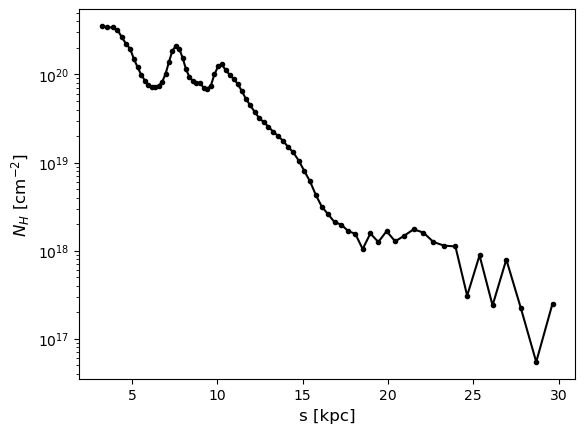

In [86]:
#Taking a look at the Radio Astronomy Manual (eq. 13.8), and taking our assumptions:
def NH_bin(Tb, dv):
    return 1.82e18*Tb*dv

NH_bins = NH_bin(spec.T_b,spec.dv)

f,ax=subplots(1,dpi=100)
ax.semilogy(spec.s_, NH_bins,'k.-')
ax.set_xlabel('s [kpc]',fontsize=12)
ax.set_ylabel(r'$N_H \ \mathrm{[cm^{-2}]}$',fontsize=12)

### Part c
Using this model, each measurement comes from a single $ds$ along the line of sight, so we can approximate the volume density of H atoms as a function of distance as $n_H \sim N_H / ds$.
Use the quantities to calculate $n_H$ for each point and plot with respect to the galactocentric radius $R_{gc}$. 

As a comparison, on the same plot, plot the average midplane number density of neutral hydrogen from Kalberla and Kerp (Section 3.1.3)

How does your derived number density along your single line of sight compare to the smoothed profile of the galactic average?


Text(0, 0.5, '$n_H \\ \\mathrm{[cm^{-3}]}$')

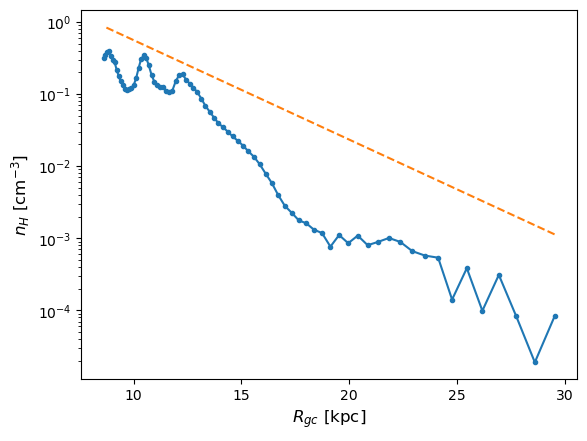

In [87]:
ds = spec.ds*3.086e21 #converting the ds value from the class spec from kpc to cm
n0 = 0.9 #cm^-3
Rn = 3.15 #kpc, (section 3.1.3)
R_sol = 8.5 # kpc (section 3.1.1)
nh_bins = NH_bins/ds

def n_kk(Rgc):
    power = -(Rgc-R_sol)/Rn
    return n0*np.exp(power)
    

f,ax = subplots(1,dpi=100)
ax.semilogy(spec.r_,nh_bins,'.-')
ax.semilogy(spec.r_, n_kk(spec.r_),'--')
ax.set_xlabel(r'$R_{gc}$ [kpc]',fontsize=12)
ax.set_ylabel(r'$n_H \ \mathrm{[cm^{-3}]}$',fontsize=12)


The derived density greatly underestimates the number density of hydrogen atoms.

### Part d: *Menu* points (Optional)
For a menu point for this week, write a script to perform the above analysis for multiple spectra taken along different lines of sight $l$. Make the plot for Part c, with the nH(r) plotted for every $l$. How does the average of those lines compare to the galactic average?

For these purposes, you might find it useful to download spectrum files using python, below is a code that will request a file at a specific galactic longitude from the survey. 

In [ ]:
import requests

long = '100.00'
url = "https://www.astro.uni-bonn.de/hisurvey/AllSky_profiles/download.php?ral="+long+"&decb=0.00&csys=0&beam=0.200"

s = requests.Session()
response = s.get(url)

with open('spec'+long+'.txt', 'wb') as file:
    file.write(response.content)

## II. Equilibrum Temperature of the ISM




Let's build an ISM thermal model.
We'll need sources of heating and cooling.
We're going to pull from some models in [Wolfire,2003](https://ui.adsabs.harvard.edu/abs/2003ApJ...587..278W/abstract)

We're going to use:
1. CII cooling (Eq. C1 in Wolfire, 2003)
2. OI cooling (Eq., C3 in Wolfire 2003)
3. Lyman-alpha cooling, given by:

$n^2 \Lambda_{Ly\alpha} = 2.0\times 10^{-21}\left({n_e/n_H\over 10^{-4}}\right)^2 n_H^2\left({8000\over T}\right)^{1/2} \,e^{-1.2\times 10^5/T} {\rm erg/s/cm^3}$ 

For heating we will include:
1. Photoelectric grain heating (Eq. C5 in Wolfire 2003)
2. Cosmic-ray heating, given by:
$ \begin{align} n \Gamma_{CR} &= n_H \zeta_H \langle E \rangle \\ &= 5.4\times 10^{-28}\left({n_H\over 1\,{\rm cm}^{-3}}\right) \left({\zeta_H\over 10^{-16}\,{\rm s}^{-1}}\right) \left({\langle E\rangle\over 3.4\,{\rm eV}}\right) {\rm erg/s/cm^3}. \end{align} $

We'll also need the electron density, for which you can use Eq. C15 from Wolfire, 2003. 

Assume a cosmic ray ionization rate of $\zeta_H = 1.3 \times 10^{-16} /s $ and a PAH fraction of 0.5. 
For the equations from Wolfire, 2003, assume values at the solar circle. (i.e. every term with a prime (for ex. $G_0^\prime$) is set to 1.)







### Part a

Write a function for each heating and cooling term in terms of $T$ and $n$. Remember that conventions can change between papers, so pay attention to the units.

Make a plot of the heating and cooling contributions as a function of temperature with one panel at $n = 1 \mathrm{cm^{-3}}$.

Write a caption for the plot describing the dominant sources of heating and cooling at different temperatures.

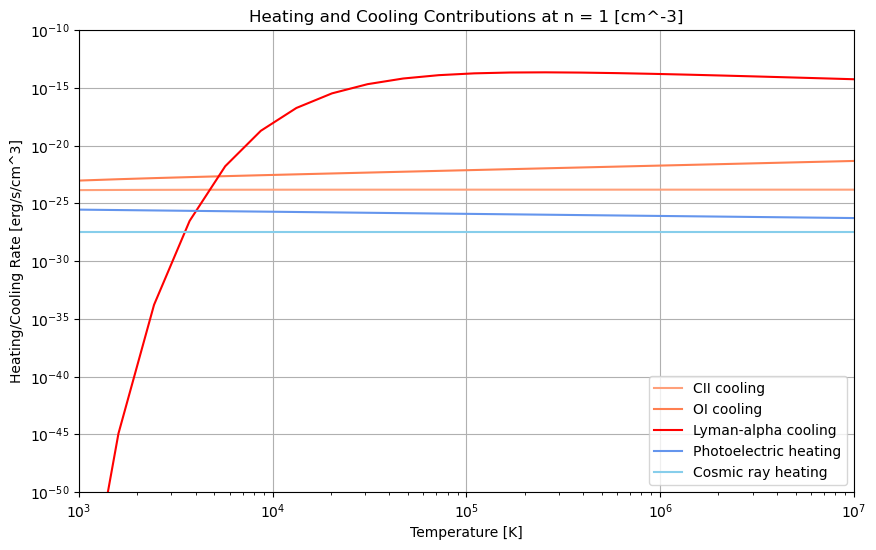

In [76]:
#constants to use
zeta_H = 1.3e-16  #cosmic ray ionization rate in 1/s
E_avg = 3.4  #average cosmic ray energy in eV
PAH = 0.5  #PAH from standard model
G0_prime = 1.0  #at the solar circle
Zd_prime = 1.0 #at the solar circle
Zeta_prime = 1.0 #at the solar circle
T = np.logspace(1, 10)  #temp range in Kelvins
T_2 = T/100
n_H = np.ones_like(T)  #hydrogen number density in cm^-3 (also I just learned about ones_like...)


#electron density from Wolfire, 2003 (eq. C15)
def n_e(T):
    return (2.4e-3*(T**(1/4))*(Zeta_prime*G0_prime*Zd_prime)**(-1/2))/PAH

#cooling
def CII_cooling(T, n):#3.15e-27
    return 1.54e-24*np.exp(-0.92/T)*Zeta_prime*(n**2)

def OI_cooling(T, n):#2.5e-27
    return 4.7e-24*(T**0.4)*np.exp(-2.28/T)*Zeta_prime*(n**2)

def Lya_cooling(T, n):
    return 2.0e-21*((1/1.0e-4)**2)*(n**2)*((8000/T)**0.5)*np.exp(-1.2e5/T)

#heating
def photoelectric_heating(T, n):#1.1e-25
    power = (G0_prime*np.sqrt(T)/n_e(T)*PAH)**0.73
    return 1.3e-24*(G0_prime)*(Zd_prime)*n/power

def cosmicray_heating(T, n):
    return 1.5e-12*n*zeta_H*E_avg*PAH

plt.figure(figsize=(10, 6))

#cooling
plt.plot(T, CII_cooling(T_2, n_H), label='CII cooling', color='lightsalmon')
plt.plot(T, OI_cooling(T_2, n_H), label='OI cooling', color='coral')
plt.plot(T, Lya_cooling(T, n_H), label='Lyman-alpha cooling', color='red')

#heating
plt.plot(T, photoelectric_heating(T_2, n_H), label='Photoelectric heating', color='cornflowerblue')
plt.plot(T, cosmicray_heating(T, n_H), label='Cosmic ray heating', color='skyblue')

plt.yscale('log')
plt.xscale('log')
plt.xlim(1e3, 1e7)
plt.ylim(1e-50, 1e-10)
plt.xlabel('Temperature [K]')
plt.ylabel('Heating/Cooling Rate [erg/s/cm^3]')
plt.title('Heating and Cooling Contributions at n = 1 [cm^-3]')
plt.legend()
plt.grid(True)
plt.show()


It seems as though Lyman-alpha cooling is most relevant, tapering off above $10^{4.5}$. The other cooling rates, as well as the heating rates, seem to be irrevelevant... Probably due to the error on behalf of the user.  

### Part b

Write a function that calculates the total (Heating - Cooling), as a function of $n$ and $T$. 
For a range of ISM number densities between 0.01 and 100, use this function and a routine in `scipy.optimize` to numerically solve for the equilibrium temperature at each n. 

According to the cooling and heating rates we used here, what is equlibrium temperature and pressure around the canonical WNM/CNM values? 

[-126.66863395187748, -140.63640881648834, -145.77848062463784, -147.64266532821281, -148.31473360669193, -148.5565365345347, -148.64347144813394, -148.67471881642393, -148.68594912934523, -148.68998517181535]


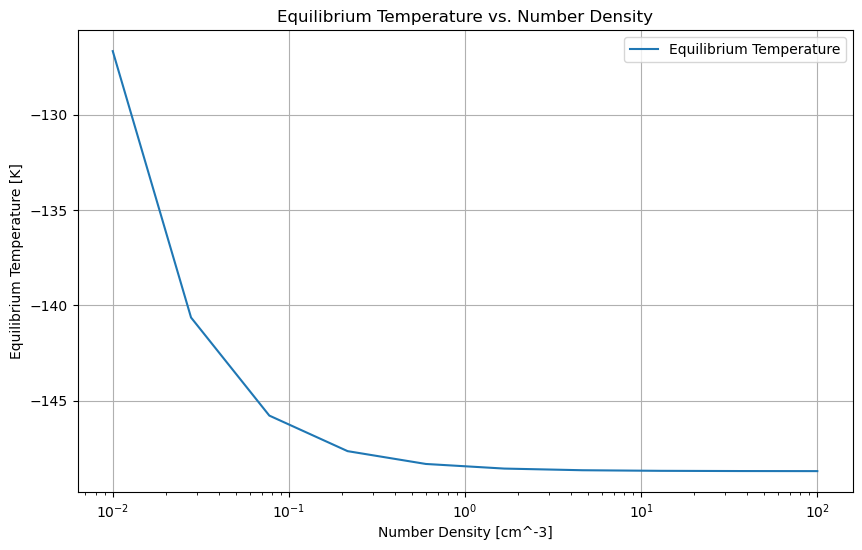

In [81]:
#basically creating a function 
def tot_hc(T, n):
    tot_cooling = CII_cooling(T, n)+OI_cooling(T, n)+Lya_cooling(T, n)
    tot_heating = photoelectric_heating(T, n) + cosmicray_heating(T, n)
    return tot_heating - tot_cooling

equilibrium_temps = [] #opening an array to add to
ism_n_densities = np.logspace(-2, 2, 10) #from 1e-2 to 1e2

for n in ism_n_densities:
    init_guess = 100
    def solve_eq(T):
        return tot_hc(T, n)
    solve_eq = sp.optimize.newton(func=solve_eq, x0=init_guess ,tol=1e4, maxiter=10) #solving for function to find the root of, the initial guess, and args
    equilibrium_temps.append(solve_eq)
print(equilibrium_temps)

plt.figure(figsize=(10, 6))
plt.plot(ism_n_densities, equilibrium_temps, label='Equilibrium Temperature')
plt.xscale('log')
plt.xlabel('Number Density [cm^-3]')
plt.ylabel('Equilibrium Temperature [K]')
plt.title('Equilibrium Temperature vs. Number Density')
plt.legend()
plt.grid(True)
plt.show()    

Here, we know that our values for the WNM and CNM are around $10^4$ Kelvins and $10^1$ Kelvins respectively... Which are not showing up at all... So there's clearly something wrong with the way the temperature array is being calculated.

### Part c
Plot the equilibrium pressure vs. the number density and compare to the FGH curve solution we discussed in class. 